In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
print("Environment Ready")

Environment Ready


In [15]:
import open3d as o3d
import numpy as np

# Load the .ply file
ply_file_path = "dataset/room_floor0.ply"
point_cloud = o3d.io.read_point_cloud(ply_file_path)

# Create a visualization window
vis = o3d.visualization.Visualizer()
vis.create_window(width=848, height=480)

# Add the point cloud to the visualization
vis.add_geometry(point_cloud)

# Define camera extrinsic parameters (pose)
camera_pose = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],  # Move the camera 5 units back along the z-axis
    [0, 0, 0, 1]
])

# Create a coordinate frame representing the camera
camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])
camera_frame.transform(camera_pose)

# Add the camera frame to the visualization
vis.add_geometry(camera_frame)

# Visualize the point cloud with the camera pose
vis.run()
vis.destroy_window()

In [12]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Start streaming
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

pipeline.start(config)
pc = rs.pointcloud()


try:
    # Wait for a coherent pair of frames: depth and color
    while True:
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        if not depth_frame or not color_frame:
            continue

        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        # Stack both images horizontally
        images = np.hstack((color_image, depth_colormap))

        # Show images
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', images)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            # Save point cloud to file
            pc = rs.pointcloud()
            points = pc.calculate(depth_frame)
            pc.map_to(color_frame)
            points.export_to_ply('dataset/room_floor9.ply', color_frame)


            np.savetxt('depth_image.txt', depth_image, fmt='%d')
            break

finally:
    # Stop streaming
    pipeline.stop()
    cv2.destroyAllWindows()


QObject::moveToThread: Current thread (0x3cbd1d0) is not the object's thread (0x3db3cd0).
Cannot move to target thread (0x3cbd1d0)

QObject::moveToThread: Current thread (0x3cbd1d0) is not the object's thread (0x3db3cd0).
Cannot move to target thread (0x3cbd1d0)

QObject::moveToThread: Current thread (0x3cbd1d0) is not the object's thread (0x3db3cd0).
Cannot move to target thread (0x3cbd1d0)

QObject::moveToThread: Current thread (0x3cbd1d0) is not the object's thread (0x3db3cd0).
Cannot move to target thread (0x3cbd1d0)

QObject::moveToThread: Current thread (0x3cbd1d0) is not the object's thread (0x3db3cd0).
Cannot move to target thread (0x3cbd1d0)

QObject::moveToThread: Current thread (0x3cbd1d0) is not the object's thread (0x3db3cd0).
Cannot move to target thread (0x3cbd1d0)

QObject::moveToThread: Current thread (0x3cbd1d0) is not the object's thread (0x3db3cd0).
Cannot move to target thread (0x3cbd1d0)

QObject::moveToThread: Current thread (0x3cbd1d0) is not the object's thread

-3.0444998741149902 -0.1947999894618988
-2.0069985389709473 0.38691219687461853
-0.1713605523109436 1.149235486984253


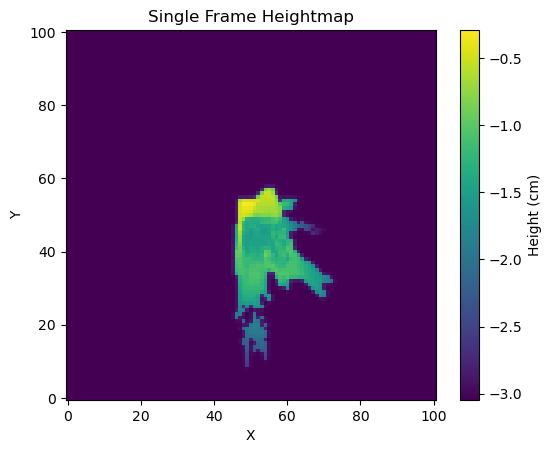

In [34]:
# reading ply file and converting to heightmap
import open3d as o3d
import numpy as np
from numpy.linalg import eig
from scipy.stats import norm
pcd = o3d.io.read_point_cloud("dataset/room_floor8.ply")

precision = 100   # number of points in heightmap per meter

points_og = np.asarray(pcd.points)
points = []
for point in points_og:
    if point[0]**2 + point[1]**2 + point[2]**2 < 3.25**2:   # filter
        points.append(point)
points = np.array(points)


# want to transform the points to the world coordinate system at this point given camera pose
def rotation_matrix_from_euler(roll, pitch, yaw):
    # Calculate individual rotation matrices
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_y = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    R_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    
    # Combine the rotation matrices
    R = np.dot(R_z, np.dot(R_y, R_x))
    
    # Convert to homogeneous coordinates
    R_homogeneous = np.eye(4)
    R_homogeneous[:3, :3] = R
    
    return R_homogeneous

roll = np.radians(0)  # Roll angle in radians
pitch = np.radians(0)  # Pitch angle in radians
yaw = np.radians(0)  # Yaw angle in radians

rotation_matrix = rotation_matrix_from_euler(roll, pitch, yaw)

# Rotation code: restudy homogeneous later
# Convert points to homogeneous coordinates by adding a column of ones
points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))
# Apply the rotation matrix to the points
rotated_points_homogeneous = points_homogeneous.dot(rotation_matrix.T)
# Convert back to Cartesian coordinates by removing the homogeneous coordinate
rotated_points = rotated_points_homogeneous[:, :3]

points = rotated_points

min_x = 100000
max_x = -100000
min_y = 100000
max_y = -100000
min_ele = 100000
max_ele = -100000

for point in points:
    min_x = min(min_x, point[0])
    max_x = max(max_x, point[0])
    min_y = min(min_y, point[1])
    max_y = max(max_y, point[1])
    min_ele = min(min_ele, point[2])
    max_ele = max(max_ele, point[2])


print(min_ele, max_ele)
print(min_x, max_x)
print(min_y, max_y)

N = 200
heightmap = np.zeros((N, N), dtype=np.float32)
heightmap.fill(min_ele)

point_heights = np.zeros((N, N), dtype=object)
for i in range(N):
    for j in range(N):
        point_heights[i, j] = []

for point in points:
    x = int((N/10)*(point[0] + 5))
    y = int((N/10)*(point[1] + 5))
    point_heights[x, y].append(point[2])



for row in range(0,N):
    for col in range(0,N):
        avg = 0
        for point in point_heights[row, col]:
            avg += point
        if len(point_heights[row, col]) == 0:
            heightmap[row][col] = min_ele
        else:
            avg = avg / len(point_heights[row, col])
            heightmap[row][col] = avg

from scipy.ndimage import gaussian_filter
# Apply Gaussian filtering to smooth the heightmap
sigma = .45 # Adjust this value to control the level of smoothing
heightmap = gaussian_filter(heightmap, sigma=sigma)


heightmap = heightmap[50:151, 50:151]

# Visualize the heightmap using matplotlib
plt.imshow(heightmap, cmap='viridis', origin='lower')
plt.colorbar(label='Height (cm)')
plt.title('Single Frame Heightmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [3]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from datetime import datetime
from scipy.stats import norm
from numpy.linalg import eig


# calibrate this wall? why is it sloping? bug here?
def rotation_matrix_from_euler(roll, pitch, yaw):
    # Calculate individual rotation matrices
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_y = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    R_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    
    # Combine the rotation matrices
    R = np.dot(R_z, np.dot(R_y, R_x))
    
    # Convert to homogeneous coordinates
    R_homogeneous = np.eye(4)
    R_homogeneous[:3, :3] = R
    
    return R_homogeneous

class Heightmap:
    def __init__(self, ply_file, yaw, precision=100, sigma=0.45, subset_range=(50, 151)):
        self.ply_file = ply_file
        self.precision = precision          # number of points in heightmap per meter
        self.sigma = sigma                  # level of smoothing
        self.subset_range = subset_range
        self.timestamp = datetime.now()
        self.heightmap = None
        self.layers = []
        self.min_x = None                   # used for initial framing
        self.max_x = None
        self.min_y = None
        self.max_y = None
        self.min_z = None                 
        self.max_z = None
        self._generate_heightmap(yaw)       # janky way adjusting camera pose for now

    def _generate_heightmap(self, rotation):
        # Load point cloud
        pcd = o3d.io.read_point_cloud(self.ply_file)
        points_og = np.asarray(pcd.points)
        
        # Filter points
        points = [point for point in points_og if point[0]**2 + point[1]**2 + point[2]**2 < 2**2]   #3.25
        points = np.array(points)

        # Define transformation matrix
        dataset_yaw = [0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180]
        roll = np.radians(0)
        pitch = np.radians(0)
        yaw = np.radians(dataset_yaw[rotation])    # Rotation domain: [0,8]
        rotation_matrix = rotation_matrix_from_euler(roll, pitch, yaw)

        # Rotation code: restudy homogeneous later
        # Convert points to homogeneous coordinates by adding a column of ones
        points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))
        # Apply the rotation matrix to the points
        rotated_points_homogeneous = points_homogeneous.dot(rotation_matrix.T)
        # Convert back to Cartesian coordinates by removing the homogeneous coordinate
        rotated_points = rotated_points_homogeneous[:, :3]
        points = rotated_points

        # Initialize min/max values
        self.min_x = np.min(points[:, 0])
        self.max_x = np.max(points[:, 0])
        self.min_y = np.min(points[:, 1])
        self.max_y = np.max(points[:, 1])
        self.min_z = np.min(points[:, 2])
        self.max_z = np.max(points[:, 2])

        # Create heightmap
        N = 200
        heightmap = np.zeros((N, N), dtype=np.float32)
        heightmap.fill(self.min_y)
        seen = np.zeros((N, N), dtype=bool)     # Keep track of which points have been seen

        point_heights = np.zeros((N, N), dtype=object)
        for i in range(N):
            for j in range(N):
                point_heights[i, j] = []

        for point in points:
            x = int((N / 10) * (point[0] + 5))
            z = int((N / 10) * (point[2] + 5))
            point_heights[x, z].append(point[1])
            seen[x, z] = True

        for row in range(N):
            for col in range(N):
                avg = 0
                for point in point_heights[row, col]:
                    avg += point
                if len(point_heights[row, col]) == 0:
                    heightmap[row][col] = self.min_y
                else:
                    avg = avg / len(point_heights[row, col])
                    heightmap[row][col] = avg

        # Apply Gaussian filtering to smooth the heightmap
        # Get rid of this soon?
        # heightmap = gaussian_filter(heightmap, sigma=self.sigma)

        # Slice the heightmap to zoom in
        start, end = self.subset_range
        self.heightmap = heightmap[start:end, start:end]
        self.layers.append(seen)
    
    def naive_heightmap_fuse(self, other_heightmap):
        if self.heightmap.shape != other_heightmap.heightmap.shape:
            raise ValueError("Heightmaps must have the same dimensions to be fused.")
        fused_heightmap = (self.heightmap + other_heightmap.heightmap) / 2
        self.heightmap = fused_heightmap
        return fused_heightmap

    def fuse_min(self, points_file, pose):
        # Load point cloud
        pcd = o3d.io.read_point_cloud(points_file)
        points_og = np.asarray(pcd.points)
        # Filter points
        newpoints = [point for point in points_og if point[0]**2 + point[1]**2 + point[2]**2 < 2**2]
        newpoints = np.array(newpoints)

        # Define transformation matrix

        dataset_yaw = [0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180]
        roll = np.radians(0)
        pitch = np.radians(0)
        yaw = np.radians(dataset_yaw[pose])    # Rotation domain: [0,8]
        rotation_matrix = rotation_matrix_from_euler(roll, pitch, yaw)

        # Rotation code: restudy homogeneous later
        # Convert points to homogeneous coordinates by adding a column of ones
        points_homogeneous = np.hstack((newpoints, np.ones((newpoints.shape[0], 1))))
        # Apply the rotation matrix to the points
        rotated_points_homogeneous = points_homogeneous.dot(rotation_matrix.T)
        # Convert back to Cartesian coordinates by removing the homogeneous coordinate
        rotated_points = rotated_points_homogeneous[:, :3]
        newpoints = rotated_points
        heightmap = self.heightmap
        N = 200

        point_heights = np.zeros((N, N), dtype=object)
        for i in range(N):
            for j in range(N):
                point_heights[i, j] = []

        # twice as zoomed in here as in the original heightmap because of 50,150 zooming -> N/20
        for point in newpoints:
            x = int((N / 20) * (point[0] + 5))
            z = int((N / 20) * (point[2] + 5))
            if (x < 100 and x > 0) and (z < 100 and z > 0):
                point_heights[x, z].append(point[1])

        # print("New points:" + str(pose))
        # for point in newpoints:
        #     x = int((N / 20) * (point[0] + 5))
        #     y = int((N / 20) * (point[1] + 5))
        #     if not (x < 100 and x > 0) and (y < 100 and y > 0):
        #         print("x: " + str(x) +", y: " + str(y) + ", z: " + str(point[2]))
        #         print("x: " + str(point[0]) +", y: " + str(point[1]) + ", z: " + str(point[2]))

        for row in range(N):
            for col in range(N):
                avg = 0
                for point in point_heights[row, col]:
                    avg += point
                if len(point_heights[row, col]) != 0:
                    avg = avg / len(point_heights[row, col])
                    # Different behavior if column is empty or populated
                    if self.layers[0][row][col] == False:
                        heightmap[row][col] = avg
                        self.layers[0][row][col] = True
                    else:
                        heightmap[row][col] = (avg + self.heightmap[row][col]) / 2
                        # heightmap[row][col] = max(avg, self.heightmap[row][col])
                        # heightmap[row][col] = min(avg, self.heightmap[row][col])

        self.heightmap = heightmap


    def visualize(self):
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D
        # Visualize the heightmap using matplotlib
        plt.imshow(self.heightmap, cmap='viridis', origin='lower')
        plt.colorbar(label='Height (cm)')
        plt.title('Single Frame Heightmap')
        plt.xlabel('X')
        plt.ylabel('Z')
        plt.show()

    def visualize3d(self):
        # Assuming self.heightmap is a 2D numpy array
        heightmap = self.heightmap

        # Create a meshgrid for the X and Y coordinates
        x = np.arange(heightmap.shape[1])
        y = np.arange(heightmap.shape[0])
        x, y = np.meshgrid(x, y)

        # Create a figure and a 3D axis
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
        surf = ax.plot_surface(x, y, heightmap, cmap='viridis')

        # Add a color bar which maps values to colors
        fig.colorbar(surf, ax=ax, label='Height (cm)')

        # Set labels and title
        ax.set_title('Single Frame Heightmap')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Height (cm)')

        # Show the plot
        plt.show()
    def visualizeint(self):
        import plotly.graph_objects as go
        heightmap = self.heightmap

        # Create a meshgrid for the X and Y coordinates
        x = np.arange(heightmap.shape[1])
        y = np.arange(heightmap.shape[0])
        x, y = np.meshgrid(x, y)

        # Create the 3D surface plot
        fig = go.Figure(data=[go.Surface(z=heightmap, x=x, y=y, colorscale='Viridis')])
        origin_marker = go.Scatter3d(
            x=[50], y=[50], z=[0],
            mode='markers',
            marker=dict(size=10, color='red'),
            name='Origin'
        )
        fig.add_trace(origin_marker)

        # Update the layout for better visualization
        fig.update_layout(
            title='Single Frame Heightmap',
            scene=dict(
                xaxis_title='X',
                yaxis_title='Z',
                zaxis_title='Height (cm)'
            ),
            coloraxis_colorbar=dict(
                title='Height (cm)'
            )
        )

        # Show the plot
        fig.show()

# Usage
heightmap1 = Heightmap("dataset/room_floor0.ply", 0)
# heightmap1.fuse_min("dataset/room_floor1.ply", 1)
# heightmap1.fuse_min("dataset/room_floor2.ply", 2)
# heightmap1.fuse_min("dataset/room_floor3.ply", 3)
# heightmap1.fuse_min("dataset/room_floor4.ply", 4)
# heightmap1.fuse_min("dataset/room_floor5.ply", 5)
# heightmap1.fuse_min("dataset/room_floor6.ply", 6)
# heightmap1.fuse_min("dataset/room_floor7.ply", 7)
# heightmap1.fuse_min("dataset/room_floor8.ply", 8)

heightmap1.visualizeint()



[Open3D WARNING] Read PLY failed: unable to open file: dataset/room_floor0.ply


ValueError: shapes (0,2) and (4,4) not aligned: 2 (dim 1) != 4 (dim 0)

In [ ]:
# Ensure points is a 2D array
if points.ndim == 1:
    points = points.reshape(-1, 1)

# Convert points to homogeneous coordinates by adding a column of ones
points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))

In [ ]:
# Ensure points is a 2D array
if points.ndim == 1:
    points = points.reshape(-1, 1)

# Convert points to homogeneous coordinates by adding a column of ones
points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))

In [ ]:
# Ensure points is a 2D array
if points.ndim == 1:
    points = points.reshape(-1, 1)

# Convert points to homogeneous coordinates by adding a column of ones
points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))

In [ ]:
# Ensure points is a 2D array
if points.ndim == 1:
    points = points.reshape(-1, 1)

# Convert points to homogeneous coordinates by adding a column of ones
points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))

In [ ]:
# Ensure points is a 2D array
if points.ndim == 1:
    points = points.reshape(-1, 1)

# Convert points to homogeneous coordinates by adding a column of ones
points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))

In [ ]:
# Ensure points is a 2D array
if points.ndim == 1:
    points = points.reshape(-1, 1)

# Convert points to homogeneous coordinates by adding a column of ones
points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))

In [ ]:
# Ensure points is a 2D array
if points.ndim == 1:
    points = points.reshape(-1, 1)

# Convert points to homogeneous coordinates by adding a column of ones
points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))

In [ ]:
# Ensure points is a 2D array
if points.ndim == 1:
    points = points.reshape(-1, 1)

# Convert points to homogeneous coordinates by adding a column of ones
points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))